# Implementation of Differentially-private GAN (DP-WGAN) on Worldline credit card transactions dataset

Worldline has open sourced some of their data of credit card transactions to try to predict fraud:

https://www.kaggle.com/mlg-ulb/creditcardfraud

Although this dataset is public, it might still contain personally identifiable information which could be reverse-engineered.

In this this notebook, a DP-WGAN is implemented to generate a synthetic copy of this dataset which preserves as much of the structure as possible, but obfuscates the raw observations. 
To gauge the quality of the synthetic data, a classifier is trained on it to test its performance on a held-out set of observations from the original data. 

In [65]:
%config Completer.use_jedi = False

In [254]:
from dpwgan import DPWGAN
import torch.nn as nn
import torch
import logging
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import logging

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.special import expit
import collections
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [3]:
df_xy = pd.read_csv('./data/creditcard.csv')

In [4]:
df_xy.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Checking for Null values

In [5]:
df_xy.isnull().sum().max()

0

## Checking balance

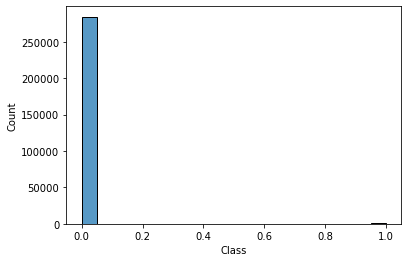

In [6]:
sns.histplot(df_xy['Class'])

In [7]:
df_xy[df_xy['Class']==1].shape

(492, 31)

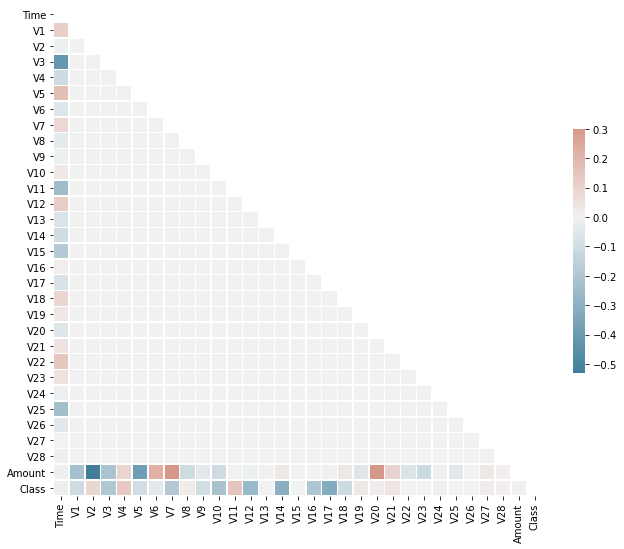

In [8]:
corr = df_xy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
df_x = df_xy.drop(['Class'],axis=1)
df_y = df_xy['Class']
df_x_0 = df_xy[df_xy['Class']==0].drop(['Class'],axis=1)
#df_x_0 = df_x_0[(np.abs(stats.zscore(df_x_0.iloc[:,1:])) < 3).all(axis=1)] ## removing outliers
df_x_1 = df_xy[df_xy['Class']==1].drop(['Class'],axis=1)

## Defining Generator and Discriminator models:

In [58]:
class Generator(nn.Module):
    def __init__(self,noise_dim,hidden_dim,n_features):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_features)
        )

    def forward(self, input):
        return self.main(input)

In [59]:
class Discriminator(nn.Module):
    def __init__(self,hidden_dim,n_features):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [57]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

## DPWGAN
The differentially private Wasserstein GAN (DPWGAN) implementation is taken from [https://github.com/civisanalytics/dpwgan](https://github.com/civisanalytics/dpwgan) (with a minor revision) and is based on [this paper](https://arxiv.org/abs/1802.06739). Given the siginicant imbalance between the two classes, a separate unconditional GAN is trained for each class. Alternatively, stratified samling could be used to train a single conditional GAN to generate data from both classes.

In [63]:
class DPWGAN_enhanced(object):
    def __init__(self, noise_function,noise_dim,hidden_dim,n_features,device=device):
        self.generator = Generator(noise_dim,hidden_dim,n_features).to(device)
        self.discriminator = Discriminator(hidden_dim,n_features).to(device)
        self.noise_function = noise_function
        
        self.generator.apply(init_weights)
        self.discriminator.apply(init_weights)

    def train(self, data, epochs=100, n_critics=5, batch_size=128,
              learning_rate=1e-4, sigma=None, weight_clip=0.1):
        """Train the model
        Parameters
        ----------
        data : torch.Tensor
            Data for training
        epochs : int
            Number of iterations over the full data set for training
        n_critics : int
            Number of discriminator training iterations
        batch_size : int
            Number of training examples per inner iteration
        learning_rate : float
            Learning rate for training
        sigma : float or None
            Amount of noise to add (for differential privacy)
        weight_clip : float
            Maximum range of weights (for differential privacy)
        """
        generator_solver = optim.RMSprop(
            self.generator.parameters(), lr=learning_rate
        )
        discriminator_solver = optim.RMSprop(
            self.discriminator.parameters(), lr=learning_rate
        )

        # add hooks to introduce noise to gradient for differential privacy
        if sigma is not None:
            for parameter in self.discriminator.parameters():
                parameter.register_hook(
                    lambda grad: grad + (1 / batch_size) * sigma
                    * torch.randn(parameter.shape,device=device)
                )

        # There is a batch for each critic (discriminator training iteration),
        # so each epoch is epoch_length iterations, and the total number of
        # iterations is the number of epochs times the length of each epoch.
        epoch_length = len(data) / (n_critics * batch_size)
        n_iters = int(epochs * epoch_length)
        for iteration in range(n_iters):
            for _ in range(n_critics):
                # Sample real data
                rand_perm = torch.randperm(data.size(0)).to(device)
                samples = data[rand_perm[:batch_size]]
                real_sample = Variable(samples)

                # Sample fake data
                fake_sample = self.generate(batch_size)

                # Score data
                discriminator_real = self.discriminator(real_sample)
                discriminator_fake = self.discriminator(fake_sample)

                # Calculate discriminator loss
                # Discriminator wants to assign a high score to real data
                # and a low score to fake data
                discriminator_loss = -(
                    torch.mean(discriminator_real) -
                    torch.mean(discriminator_fake)
                )

                discriminator_loss.backward()
                discriminator_solver.step()

                # Weight clipping for privacy guarantee
                for param in self.discriminator.parameters():
                    param.data.clamp_(-weight_clip, weight_clip)

                # Reset gradient
                self.generator.zero_grad()
                self.discriminator.zero_grad()

            # Sample and score fake data
            fake_sample = self.generate(batch_size)
            discriminator_fake = self.discriminator(fake_sample)

            # Calculate generator loss
            # Generator wants discriminator to assign a high score to fake data
            generator_loss = -torch.mean(discriminator_fake)

            generator_loss.backward()
            generator_solver.step()

            # Reset gradient
            self.generator.zero_grad()
            self.discriminator.zero_grad()

            # Print training losses
            #if int(iteration % epoch_length) == 0:
            if iteration%100 == 0:
                epoch = int(iteration / epoch_length)
                _logger.info('Epoch {}\n'
                             'Discriminator loss: {}; '
                             'Generator loss: {}'
                             .format(epoch,
                                     discriminator_loss.data.cpu().numpy(),
                                     generator_loss.data.cpu().numpy()))
    def generate(self, n):
        """Generate a synthetic data set using the trained model
        Parameters
        ----------
        n : int
            Number of data points to generate
        Returns
        -------
        torch.Tensor
        """
        noise = self.noise_function(n)
        fake_sample = self.generator(noise)
        return fake_sample        

## Normalizing the data

In [134]:
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(df_x)

### Retain 20% of the original dataset as test data for classifier trained on the synthetic data

In [135]:
X_train, X_test_orig, y_train, y_test_orig = train_test_split(X_std,df_xy['Class'] , test_size=0.2, random_state=10)

In [136]:
X_train_fraud = X_train[y_train==1,:]
X_train_non_fraud = X_train[y_train==0,:]

In [137]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [138]:
noise_dim = 16
hidden_dim = 32
n_features = 30

In [139]:
def noise_function(n,noise_dim=noise_dim,device=device):
    return torch.randn(n, noise_dim,device=device)

## Fine tuning the parameters to ensure that both GANs are ($\epsilon$,$\delta$)-differentially priavet:
The value of $\delta$ is fixed at 1e-5. To train the GAN under different levels of differential privacy, 3 different values of privacy constraint, $\epsilon$, is considered (0.1,1,2) and for each value the corresponding *number of epochs* and *noise multiplier* is calculated for each of the two GANs to ensure that both have same level of differential privacy

In [151]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy

In [ ]:
df_epsilon = pd.DataFrame(columns=['sigma','epochs','n_samples','epsilon'])
SIGMA = 10
batch_size_fraud = 16
sigma_epsilon_fraud_dic = {}
i = 0
batch_size = batch_size_fraud
for n_samples in [X_train_fraud.shape[0],X_train_non_fraud.shape[0]]:
    if n_samples == X_train_non_fraud.shape[0]:
                batch_size = 1024
    print(batch_size)
    for epochs in np.unique(np.logspace(1, 5, num=50).astype('int')):
        for sigma in np.logspace(-1, 2, num=30):
            if n_samples == X_train_non_fraud.shape[0]:
                batch_size = 1024
            epsilon,_ = compute_dp_sgd_privacy(n = n_samples,
                                   batch_size = batch_size,
                                   noise_multiplier = sigma,
                                   epochs = epochs,
                                   delta = 1e-5)
            sigma_epsilon_fraud_dic[sigma] = epsilon
            df_epsilon.loc[i] = sigma,epochs,n_samples,epsilon
            i+=1

In [240]:
df_epsilon[(df_epsilon['epsilon']>0.049) & (df_epsilon['epsilon']<0.051)]

,sigma,epochs,n_samples,epsilon
86,48.939009,14.0,398.0,0.049763
238,78.804628,37.0,398.0,0.050219
1551,14.873521,12.0,227447.0,0.050989
1703,23.950266,30.0,227447.0,0.049717
1855,38.566204,79.0,227447.0,0.050133
2007,62.101694,202.0,227447.0,0.049686
2159,100.000000,517.0,227447.0,0.049288


In [227]:
epochs_sigma_fraud = [(21,30.0),(30,4.5),(65,3.5)]  ## (n_epochs,sigma) for each level of \epsilon
epochs_sigma_non_fraud = [(17,9.2),(54,2.2),(65,1.37)] ## (n_epochs,sigma) for each level of \epsilon
dic_gans_fraud = {}
dic_gans_non_fraud = {}

## Training GANs 

In [228]:
X_train_fraud_ = torch.tensor(X_train_fraud).float().to(device)
X_train_non_fraud_ = torch.tensor(X_train_non_fraud).float().to(device)
batch_size_fraud = 16
batch_size_non_fraud = 1024
for i,epsilon in enumerate([0.1,1,2]):
    print(i)
    epochs_fraud,sigma_fraud = epochs_sigma_fraud[i]
    gan_fraud = DPWGAN_enhanced(noise_function,noise_dim=noise_dim,hidden_dim=hidden_dim,n_features=n_features)
    gan_fraud.train(X_train_fraud_,epochs=epochs_fraud,
                    n_critics=5, 
                    batch_size=batch_size_fraud,
                    learning_rate=1e-4, 
                    sigma=sigma_fraud, 
                    weight_clip=1/hidden_dim)
    dic_gans_fraud[epsilon] = gan_fraud
    epochs_non_fraud,sigma_non_fraud = epochs_sigma_non_fraud[i]
    gan_non_fraud = DPWGAN_enhanced(noise_function,noise_dim=noise_dim,hidden_dim=hidden_dim,n_features=n_features)
    gan_non_fraud.train(X_train_non_fraud_,epochs=epochs_non_fraud,
                    n_critics=5, 
                    batch_size=batch_size_non_fraud,
                    learning_rate=1e-4, 
                    sigma=sigma_non_fraud, 
                    weight_clip=1/hidden_dim)
    dic_gans_non_fraud[epsilon] = gan_non_fraud
    
    
    

0
1
2


## Fitting a Logistic Regression Classifier on synthetic data
The trained GANs are used to generate synthetic fraud and non-fraud data for each level of $\epsilon$. A logistic regression classifier is fitted on the generated data and AUROC is calculated using the held-out data from the original dataset.

In [ ]:
lr_parameters = {'C':np.logspace(-4, 4, num=500)}
AUROC = {}
dic_classifiers = {}
for i,epsilon in enumerate([0.1,1,2]):
    print(i)
    gan_fraud = dic_gans_fraud[epsilon]
    syn_data_fraud = gan_fraud.generate(5000).cpu().detach().numpy()
    
    gan_non_fraud = dic_gans_non_fraud[epsilon]
    syn_data_non_fraud = gan_non_fraud.generate(5000).cpu().detach().numpy()
    
    x_syn = np.concatenate((syn_data_non_fraud,syn_data_fraud))
    y_syn = np.zeros((x_syn.shape[0],1))
    y_syn[5000:] = 1
    
    lr = LogisticRegression(random_state=0,max_iter=1000)
    kf = KFold(n_splits=10,shuffle=True)
    clf = GridSearchCV(lr, parameters,cv=kf,verbose=1,n_jobs=12)
    clf.fit(X_train_syn,y_train_syn)
    
    clf_best_lr = clf.best_estimator_
    dic_classifiers[epsilon] = clf_best_lr 
    
    AUROC[epsilon] = roc_auc_score(y_test_orig,clf_best_lr.predict_proba(X_test_orig)[:,1])

In [41]:
from sklearn.metrics import plot_roc_curve

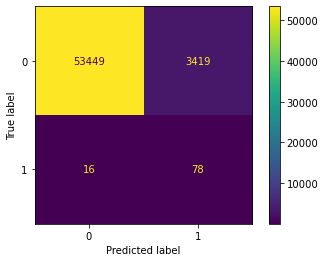

In [43]:
plot_confusion_matrix(clf, X_test_orig, y_test_orig)  